In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import PolynomialFeatures
import math
import matplotlib
from sklearn.utils import shuffle

# Load the data
mlr_data = pd.read_csv('/Users/jjy/Desktop/MLR Data/mlr_data.csv')
mlr_data = shuffle(mlr_data,random_state=1)
# Display the first few rows to understand the structure
print(mlr_data.head())

      well_id replicate_number assay_type assay_number treatment_1  \
13046     105               R2    CD8 MLR        MLR85     GEN1053   
15849     160               R1    CD8 MLR        MLR85     GEN1053   
10583      55               R2    CD8 MLR        MLR85     GEN1053   
13704     119               R1    CD8 MLR        MLR85    CD3/CD28   
20501     247               R2    CD8 MLR        MLR85        IgG4   

       concentration_1    treatment_2  concentration_2 donor_1_type  \
13046            0.000  Pembrolizumab             0.01     DC Donor   
15849            0.001  Pembrolizumab             1.00     DC Donor   
10583            1.000  Pembrolizumab             0.10     DC Donor   
13704              NaN            NaN              NaN     DC Donor   
20501            1.000            NaN              NaN     DC Donor   

              donor_1_id  donor_2_type            donor_2_id scientist  \
13046  LS 24 18861 58355  T cell Donor  LS 11 69613B CC00489      NACH   
1584

/var/folders/wx/_sxsvv513r3fmy2qd036wn500000gn/T/ipykernel_98975/3697649020.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(mlr_data[treatment_col], shade=True)


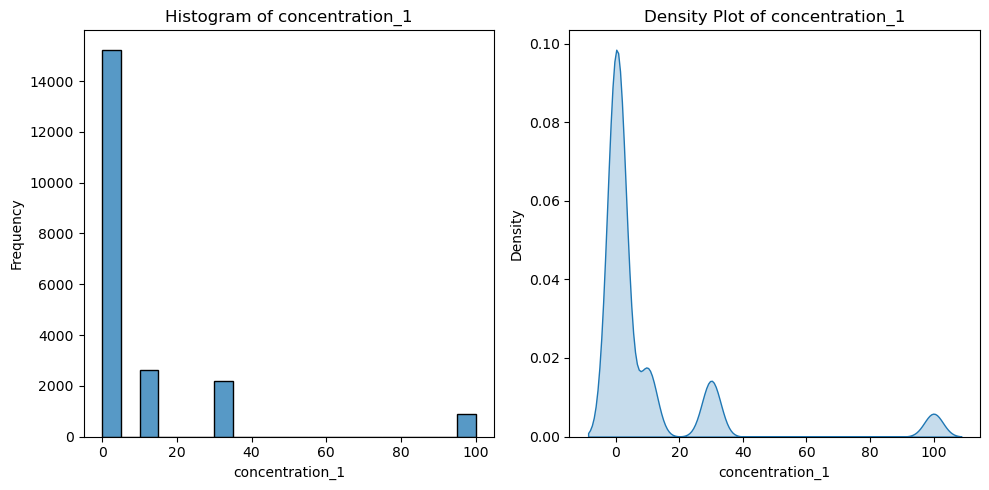

/var/folders/wx/_sxsvv513r3fmy2qd036wn500000gn/T/ipykernel_98975/3697649020.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(mlr_data[treatment_col], shade=True)


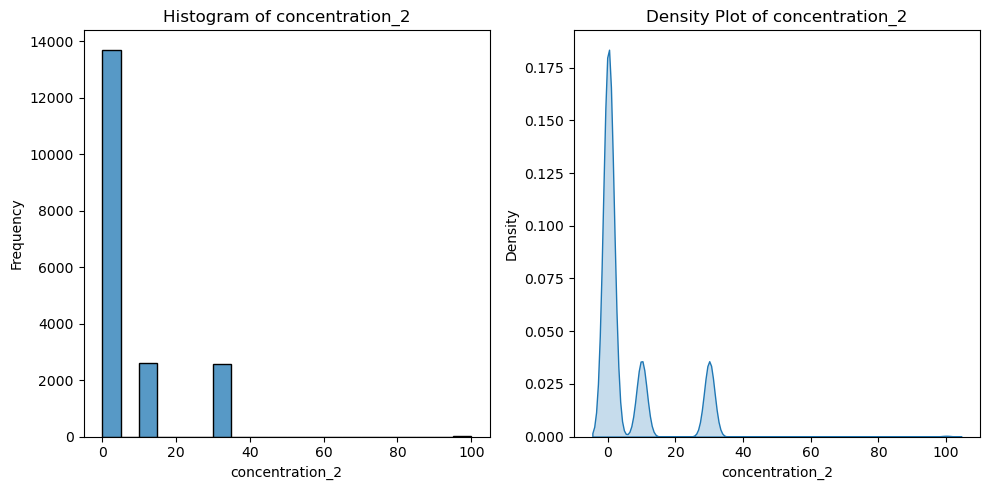

In [51]:
# Assuming the data has columns for treatments and cytokines, replace these column names with actual ones
treatment1_col = 'concentration_1'
treatment2_col = 'concentration_2'

for treatment_col in [treatment1_col, treatment2_col]:
    plt.figure(figsize=(10, 5))
    
    # Histogram plot
    plt.subplot(1, 2, 1)
    sns.histplot(mlr_data[treatment_col], kde=False, bins=20)
    plt.title(f'Histogram of {treatment_col}')
    plt.xlabel(treatment_col)
    plt.ylabel('Frequency')

    # Density plot
    plt.subplot(1, 2, 2)
    sns.kdeplot(mlr_data[treatment_col], shade=True)
    plt.title(f'Density Plot of {treatment_col}')
    plt.xlabel(treatment_col)
    plt.ylabel('Density')
    
    plt.tight_layout()
    plt.show()

In [52]:
# Loop through each unique analyte and plot, skipping if insufficient data
unique_analytes = mlr_data['analyte'].unique()

In [53]:
"""
Part of this code is adapted from https://matplotlib.org/stable/plot_types/basic/scatter_plot.html#sphx-glr-plot-types-basic-scatter-plot-py
"""

def plot_1d(treatment, analyte):
    # data_1 = mlr_data.loc[ (mlr_data["treatment_1"]==treatment) &
    #                     (mlr_data["concentration_2"]==0) &
    #                     (mlr_data["analyte"]==analyte) &
    #                     (mlr_data["donor_1_id"]=="LS 24 18861 58355") &
    #                     (mlr_data["donor_2_id"]=="LS 11 71012 CC00481")
    #                     ]
    # data_2 = mlr_data.loc[ ((mlr_data["treatment_2"]==treatment) &
    #                     (mlr_data["concentration_1"]==0)) & 
    #                     (mlr_data["analyte"]==analyte) &
    #                     (mlr_data["donor_1_id"]=="LS 24 18861 58355") &
    #                     (mlr_data["donor_2_id"]=="LS 11 71012 CC00481")
    #                     ]
    data_1 = mlr_data.loc[ (mlr_data["treatment_1"]==treatment) &
                        (mlr_data["concentration_2"]==0) &
                        (mlr_data["analyte"]==analyte)
                        ]
    data_2 = mlr_data.loc[ ((mlr_data["treatment_2"]==treatment) &
                        (mlr_data["concentration_1"]==0)) & 
                        (mlr_data["analyte"]==analyte)
                        ]
    if data_1.empty & data_2.empty:
        return
    
    X_2 = pd.DataFrame(data_2.copy()["concentration_2"]).rename(columns={"concentration_2":"concentration"})
    y_2 = pd.DataFrame(data_2.copy()["analyte_value"])
    X_1 = pd.DataFrame(data_1.copy()["concentration_1"]).rename(columns={"concentration_1":"concentration"})
    y_1 = pd.DataFrame(data_1.copy()["analyte_value"])
    X = pd.concat([X_1,X_2])
    y = pd.concat([y_1,y_2])
    corr = np.corrcoef(X.transpose().values,y.transpose().values)[0][1]
    if  (abs(corr) < 0.5) | (X.size <= 5 ):
        return
    fig, ax = plt.subplots()
    ax.scatter(X, y)
    ax.set_title("Treatment: " + str(treatment) + "   Analyte: " + str(analyte)+"  Correlation: " + str(corr)+"  Size: " + str(X.size))
    plt.show()

In [54]:
# for analyte in unique_analytes:
#     # plot_1d("Pembrolizumab","MCP-4")
#     plot_1d("GEN1053",analyte)

In [55]:
"""
Method of computation gotten and adapted from 
Taketa, K., & Pogell, B. M. (1965). Allosteric inhibition of rat liver fructose 1, 6-diphosphatase by adenosine 5'-monophosphate. Journal of Biological Chemistry, 240(2), 651-662.
Altszyler, E., Ventura, A. C., Colman-Lerner, A., & Chernomoretz, A. (2017). Ultrasensitivity in signaling cascades revisited: Linking local and global ultrasensitivity estimations. PloS one, 12(6), e0180083. https://doi.org/10.1371/journal.pone.0180083
Inspiration of designing this method is also from Rob Mulla on https://www.youtube.com/watch?v=QpzMWQvxXWk
"""
# Method to see if we can compute the Hill coefficient
def Hill_coef_computable(data,X,y):
    y_max = data[y].max()
    y_min = data[y].min()
    y_range = y_max - y_min
    X_max = data.loc[(data[y]>0.9 * y_range + y_min) & (data[y]< y_max), X]
    X_min = data.loc[(data[y]<0.1 * y_range + y_min) & (data[y]> y_min), X]
    if X_max.size == 0:
        return False
    if X_min.size == 0:
        return False
    return True


In [56]:
"""
Method of computation gotten and adapted from 
Taketa, K., & Pogell, B. M. (1965). Allosteric inhibition of rat liver fructose 1, 6-diphosphatase by adenosine 5'-monophosphate. Journal of Biological Chemistry, 240(2), 651-662.
Altszyler, E., Ventura, A. C., Colman-Lerner, A., & Chernomoretz, A. (2017). Ultrasensitivity in signaling cascades revisited: Linking local and global ultrasensitivity estimations. PloS one, 12(6), e0180083. https://doi.org/10.1371/journal.pone.0180083
"""
# Method to compute the hill coefficient
def Hill_coef(data,X,y):
    y_max = data[y].max()
    y_min = data[y].min()
    y_range = y_max - y_min
    X_90 = data.loc[data[y]>0.9 * y_range + y_min, X].min()
    X_10 = data.loc[data[y]<0.1 * y_range + y_min, X].max()
    quotient = X_90/X_10
    coef = math.log10(81)/math.log10(quotient)
    return coef

In [57]:
"""
This is based on Hill equation defined in
Neubig, R. R., Spedding, M., Kenakin, T., & Christopoulos, A. (2003). International Union of Pharmacology Committee on Receptor Nomenclature and Drug Classification. XXXVIII. Update on terms and symbols in quantitative pharmacology. Pharmacological reviews, 55(4), 597-606.
and logistic function
https://en.wikipedia.org/wiki/Logistic_function
also helped by
Han, J., & Moraga, C. (1995, June). The influence of the sigmoid function parameters on the speed of backpropagation learning. In International workshop on artificial neural networks (pp. 195-201). Berlin, Heidelberg: Springer Berlin Heidelberg.
https://en.wikipedia.org/wiki/Sigmoid_function
"""
def inverse_logistic(data,k,middle_y="NA",c=0.001):
    y_max = data.max()
    y_min = data.min()
    y_range = y_max - y_min
    y_min_new = y_min - c * y_range
    y_new = data - y_min_new
    if (middle_y == "NA") | (2 * middle_y <= y_new.max()):
        y_max_new = y_max - y_min_new + c * y_range
    else:
        y_max_new = 2 * middle_y + c * y_range
    inverse_list = y_max_new/y_new - 1
    inverse_list_1 = []
    for inverse in inverse_list:
        # if type(inverse) is float:
        # print(inverse)
        inverse_list_1.append(-math.log(inverse)/k)
    # return pd.DataFrame(inverse_list_1,columns=["y_after"])
    return inverse_list_1

In [58]:
"""This is based on the method inverse_logistic and might be based on some references it uses"""

# Building a model based on the inverse logistic preprocessing
# This part is mostly testing whether it gives the original data back after performing inverse-logistic and logistic
data_focused_1 = mlr_data.loc[ (mlr_data["treatment_1"]=="Pembrolizumab") &
                        (mlr_data["treatment_2"]=="GEN1053") &
                        (mlr_data["analyte"]=="MCP-4")
                        ]
data_focused_2 = mlr_data.loc[ (mlr_data["treatment_2"]=="Pembrolizumab") &
                        (mlr_data["treatment_1"]=="GEN1053") &
                        (mlr_data["analyte"]=="MCP-4")
                        ]
data_focused_2 = data_focused_2.rename(columns={"treatment_2":"treatment_1","treatment_1":"treatment_2","concentration_1":"concentration_2","concentration_2":"concentration_1"})
data_focused = pd.concat([data_focused_1,data_focused_2])
# print(inverse_logistic(data_focused,1))
X = data_focused[["concentration_1","concentration_2"]]
y = data_focused["analyte_value"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1)
y_max = y_train.max()
y_min = y_train.min()
y_range = y_max - y_min
# zero_y = abs(y_train-0.5 * y_range - y_min).min()
r_2_score_train_max=0
middle_y_best = 0
k_best = 1
r_2_list = []
middle_y_list = []
k_list = []
for middle_y in y_train:
    model = LinearRegression()
    c = 0.001
    for k in np.arange(start=0.01,stop=100,step=1):
        y_train_new = inverse_logistic(y_train,k,middle_y=middle_y, c=c)
        y_max = y_train.max()
        y_min = y_train.min()
        y_range = y_max - y_min
        y_min_new = y_min - c * y_range
        y_new = y_train - y_min_new
        if (middle_y == "NA") | (2 * middle_y <= y_new.max()):
            y_max_new = y_max - y_min_new + c * y_range
        else:
            y_max_new = 2 * middle_y + c * y_range
            model.fit(X_train,y_train_new)
            predictions = model.predict(X_train)
            predictions_new = []
            # for x in predictions:
            for x in y_train_new:
                output = y_max_new/(1+math.e ** (-k * x)) + y_min_new
                predictions_new.append(output)
            predictions_new = pd.DataFrame(predictions_new)
            # print(r2_score(y_train,predictions_new))
            if r_2_score_train_max < r2_score(y_train,predictions_new):
                r_2_score_train_max = r2_score(y_train,predictions_new)
                middle_y_best = middle_y
                k_best = k
            r_2_list.append(r2_score(y_train,predictions_new))
            middle_y_list.append(middle_y)
            k_list.append(k)
print(r_2_score_train_max)
print(middle_y_best,k_best)
overall_list = {}
overall_list["middle_y"]=middle_y_list
overall_list["k"]=k_list
overall_list["r_2"]=r_2_list
overall_list = pd.DataFrame(overall_list)


1.0
1019.07409667969 0.01


In [59]:
"""
This is based on the method inverse_logistic and might be based on some references it uses
Helped by 
https://www.youtube.com/watch?v=3CCkeFShB3U
https://www.youtube.com/watch?v=kE_I-5rxtEA&t=164s
"""

# Building a model based on the inverse logistic preprocessing

# print(inverse_logistic(data_focused,1))
X = data_focused[["concentration_1","concentration_2"]]
X["interaction"] = X["concentration_1"].mul(X["concentration_2"])
y = data_focused["analyte_value"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1)
y_max = y_train.max()
y_min = y_train.min()
y_range = y_max - y_min
r_2_score_train_max=0
middle_y_best = 0
k_best = 1
r_2_list = []
middle_y_list = []
k_list = []
for middle_y in y_train:
    model = LinearRegression()
    c = 0.001
    for k in np.arange(start=0.01,stop=100,step=1):
        y_train_new = inverse_logistic(y_train,k,middle_y=middle_y, c=c)
        y_max = y_train.max()
        y_min = y_train.min()
        y_range = y_max - y_min
        y_min_new = y_min - c * y_range
        y_new = y_train - y_min_new
        if (middle_y == "NA") | (2 * middle_y <= y_new.max()):
            y_max_new = y_max - y_min_new + c * y_range
        else:
            y_max_new = 2 * middle_y + c * y_range
            model.fit(X_train,y_train_new)
            predictions = model.predict(X_test)
            predictions_new = []
            # for x in predictions:
            for x in predictions:
                output = y_max_new/(1+math.e ** (-k * x)) + y_min_new
                predictions_new.append(output)
            predictions_new = pd.DataFrame(predictions_new)
            # print(r2_score(y_train,predictions_new))
            if r_2_score_train_max < r2_score(y_test,predictions_new):
                r_2_score_train_max = r2_score(y_test,predictions_new)
                middle_y_best = middle_y
                k_best = k
            r_2_list.append(r2_score(y_test,predictions_new))
            middle_y_list.append(middle_y)
            k_list.append(k)
print(r_2_score_train_max)
print(middle_y_best,k_best)
overall_list_test = {}
overall_list_test["middle_y"]=middle_y_list
overall_list_test["k"]=k_list
overall_list_test["r_2"]=r_2_list
overall_list_test = pd.DataFrame(overall_list_test)


/var/folders/wx/_sxsvv513r3fmy2qd036wn500000gn/T/ipykernel_98975/1351512840.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["interaction"] = X["concentration_1"].mul(X["concentration_2"])


0
0 1


In [60]:
"""
This is based on the method inverse_logistic and might be based on some references it uses
Helped by 
https://www.youtube.com/watch?v=3CCkeFShB3U
https://www.youtube.com/watch?v=kE_I-5rxtEA&t=164s
"""

# Building a model based on the inverse logistic preprocessing

# print(inverse_logistic(data_focused,1))

def logistic_model(treatment_1,treatment_2,analyte):
    data_focused_1 = mlr_data.loc[ (mlr_data["treatment_1"]==treatment_1) &
                            (mlr_data["treatment_2"]==treatment_2) &
                            (mlr_data["analyte"]==analyte)
                            ]
    data_focused_2 = mlr_data.loc[ (mlr_data["treatment_2"]==treatment_1) &
                            (mlr_data["treatment_1"]==treatment_2) &
                            (mlr_data["analyte"]==analyte)
                            ]
    data_focused_2 = data_focused_2.rename(columns={"treatment_2":"treatment_1","treatment_1":"treatment_2","concentration_1":"concentration_2","concentration_2":"concentration_1"})
    data_focused = pd.concat([data_focused_1,data_focused_2])
    X = data_focused[["concentration_1","concentration_2"]]
    X["interaction"] = X["concentration_1"].mul(X["concentration_2"])
    y = data_focused["analyte_value"]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1)
    y_max = y_train.max()
    y_min = y_train.min()
    y_range = y_max - y_min
    r_2_score_train_max=0
    middle_y_best = 0
    k_best = 1
    r_2_list = []
    middle_y_list = []
    k_list = []
    for middle_y in y_train:
        model = LinearRegression()
        c = 0.001
        for k in np.arange(start=0.01,stop=100,step=1):
            y_train_new = inverse_logistic(y_train,k,middle_y=middle_y, c=c)
            y_max = y_train.max()
            y_min = y_train.min()
            y_range = y_max - y_min
            y_min_new = y_min - c * y_range
            y_new = y_train - y_min_new
            if (middle_y == "NA") | (2 * middle_y <= y_new.max()):
                y_max_new = y_max - y_min_new + c * y_range
            else:
                y_max_new = 2 * middle_y + c * y_range
                model.fit(X_train,y_train_new)
                predictions = model.predict(X_test)
                predictions_new = []
                # for x in predictions:
                for x in predictions:
                    output = y_max_new/(1+math.e ** (-k * x)) + y_min_new
                    predictions_new.append(output)
                predictions_new = pd.DataFrame(predictions_new)
                # print(r2_score(y_train,predictions_new))
                if r_2_score_train_max < r2_score(y_test,predictions_new):
                    r_2_score_train_max = r2_score(y_test,predictions_new)
                    middle_y_best = middle_y
                    k_best = k
                r_2_list.append(r2_score(y_test,predictions_new))
                middle_y_list.append(middle_y)
                k_list.append(k)
    return r_2_score_train_max,middle_y_best,k_best


In [61]:
"""
The design of this method is inspired by Rob Mulla on https://www.youtube.com/watch?v=QpzMWQvxXWk
"""
def plotable(treatment_1, treatment_2, analyte):
    data_1 = mlr_data.loc[ (mlr_data["treatment_1"]==treatment_1) &
                            (mlr_data["treatment_2"]==treatment_2) &
                            (mlr_data["analyte"]==analyte)
                            ]
    data_2 = mlr_data.loc[ (mlr_data["treatment_2"]==treatment_1) &
                            (mlr_data["treatment_1"]==treatment_2) &
                            (mlr_data["analyte"]==analyte)
                            ]
    data_2 = data_2.rename(columns={"treatment_2":"treatment_1","treatment_1":"treatment_2","concentration_1":"concentration_2","concentration_2":"concentration_1"})
    data = pd.concat([data_1,data_2])
    # data_2 = data.loc[data["concentration_1"]==0]
    # data_1 = data.loc[data["concentration_2"]==0]
    # Check if the data has less than 30 samples
    if data["treatment_1"].size<30:
        return False
    return True

In [62]:
# treatments = ["GEN1056","GEN1053","Pembrolizumab"]
# treatment_1_list = []
# treatment_2_list = []
# analyte_list = []
# r_2_score_train_max_list=[]
# middle_y_best_list = []
# k_best_list = []

# treatment_1 = "GEN1056"
# for treatment_2 in ["GEN1053","Pembrolizumab"]:
#     if treatment_2 != treatment_1:
#         for analyte in unique_analytes:
#             if plotable(treatment_1,treatment_2,analyte):
#                 r_2_score_train_max,middle_y_best,k_best = logistic_model(treatment_1,treatment_2,analyte)
#                 r_2_score_train_max_list.append(r_2_score_train_max)
#                 middle_y_best_list.append(middle_y_best)
#                 k_best_list.append(k_best)
#                 treatment_1_list.append(treatment_1)
#                 treatment_2_list.append(treatment_2)
#                 analyte_list.append(analyte)
# treatment_1 = "GEN1053"
# for treatment_2 in ["Pembrolizumab"]:
#     if treatment_2 != treatment_1:
#         for analyte in unique_analytes:
#             if plotable(treatment_1,treatment_2,analyte):
#                 r_2_score_train_max,middle_y_best,k_best = logistic_model(treatment_1,treatment_2,analyte)
#                 r_2_score_train_max_list.append(r_2_score_train_max)
#                 middle_y_best_list.append(middle_y_best)
#                 k_best_list.append(k_best)
#                 treatment_1_list.append(treatment_1)
#                 treatment_2_list.append(treatment_2)
#                 analyte_list.append(analyte)

# modeling_result = {}
# modeling_result["treatment_1"]=treatment_1_list
# modeling_result["treatment_2"]=treatment_2_list
# modeling_result["analyte"]=analyte_list
# modeling_result["r_2_score"]=r_2_score_train_max_list
# modeling_result = pd.DataFrame(modeling_result)

In [63]:
# r_2_scores=[]
#     for k in np.arange(start=0.01,stop=1,step=0.1):
#         y_train_new = inverse_logistic(y_train,k)
#         # print(y_train_new.head())
#         model.fit(X_train,y_train_new)
#         predictions = model.predict(X_test)
#         predictions_new = []
#         for x in predictions:
#             output = math.e ** (-k * x)
#             output = y_max_new/(1+output)
#             predictions_new.append(output)
#         predictions_new = pd.DataFrame(predictions_new)
#         r_2_scores.append(r2_score(y_test,predictions_new))
#     r_2_scores = pd.DataFrame(r_2_scores)
#     print(r_2_scores.max())

In [64]:
# data = mlr_data.loc[
#         (mlr_data["treatment_1"] == "GEN1056") & 
#         (mlr_data["treatment_2"] == "GEN1053") & 
#         (mlr_data["analyte"] == "IL-10"), 
#         ["concentration_1", "concentration_2", "analyte_value"]
#     ]
# data_1 = data.loc[data["concentration_2"]==0]
# # print(data_1)
# print(Hill_coef(data_1,"concentration_1","analyte_value"))
# Hill_coef_computable(data_1,"concentration_1","analyte_value")

In [65]:
"""
Part of code in this method is adapted from https://matplotlib.org/stable/plot_types/3D/scatter3d_simple.html#sphx-glr-plot-types-3d-scatter3d-simple-py
and helped by other examples from the official website of matplotlib: https://matplotlib.org/stable/
"""
def plot(treatment_1, treatment_2, analyte):
    data_1 = mlr_data.loc[ (mlr_data["treatment_1"]==treatment_1) &
                            (mlr_data["treatment_2"]==treatment_2) &
                            (mlr_data["analyte"]==analyte)
                            ]
    data_2 = mlr_data.loc[ (mlr_data["treatment_2"]==treatment_1) &
                            (mlr_data["treatment_1"]==treatment_2) &
                            (mlr_data["analyte"]==analyte)
                            ]
    data_2 = data_2.rename(columns={"treatment_2":"treatment_1","treatment_1":"treatment_2","concentration_1":"concentration_2","concentration_2":"concentration_1"})
    data = pd.concat([data_1,data_2])
    
    # Check if the data is empty
    if not plotable(treatment_1, treatment_2, analyte):
        print(f"Skipping {analyte} due to insufficient data.")
        return 
    
    xs = data["concentration_1"].values
    ys = data["concentration_2"].values
    zs = data["analyte_value"].values
    X = data[["concentration_1", "concentration_2"]]
    y = zs

    # Fit a linear regression model
    model = LinearRegression()
    model.fit(data[["concentration_1", "concentration_2"]], zs)

    # Create a grid for plotting the regression plane
    x_pred = np.linspace(xs.min(), xs.max(), 30)
    y_pred = np.linspace(ys.min(), ys.max(), 30)
    x_pred, y_pred = np.meshgrid(x_pred, y_pred)
    z_pred = model.predict(np.c_[x_pred.ravel(), y_pred.ravel()]).reshape(x_pred.shape)
    
    # Compute the mean of cross validation results of r square
    r_square = -cross_val_score(model, X, y, cv=5, scoring="r2").mean()

    # Plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs, ys, zs, color='blue', label='Data points')
    ax.plot_surface(x_pred, y_pred, z_pred, color='red', alpha=0.5, rstride=100, cstride=100)
    
    # Adding contour plot
    contour = ax.contourf(x_pred, y_pred, z_pred, zdir='z', offset=zs.min(), cmap='viridis', alpha=0.5)
    fig.colorbar(contour, ax=ax, shrink=0.5, aspect=5)
    
    ax.set_xlabel(treatment_1 + " concentration")
    ax.set_ylabel(treatment_2 + " concentration")
    ax.set_zlabel(analyte + " value")
    ax.set_title(f"3D Surface Plot with Regression Plane and Contours for {analyte}" " r square: " + str(r_square))
    ax.legend()
    plt.show()
    return r_square

In [66]:
"""
Helped by 
https://www.youtube.com/watch?v=3CCkeFShB3U
https://www.youtube.com/watch?v=kE_I-5rxtEA&t=164s
"""

# Computes the r^2 of model fit on specified treatments and analyte and dimension

def r_square(treatment_1, treatment_2, analyte, dimension=1):
    data_1 = mlr_data.loc[ (mlr_data["treatment_1"]==treatment_1) &
                            (mlr_data["treatment_2"]==treatment_2) &
                            (mlr_data["analyte"]==analyte)
                            ]
    data_2 = mlr_data.loc[ (mlr_data["treatment_2"]==treatment_1) &
                            (mlr_data["treatment_1"]==treatment_2) &
                            (mlr_data["analyte"]==analyte)
                            ]
    data_2 = data_2.rename(columns={"treatment_2":"treatment_1","treatment_1":"treatment_2","concentration_1":"concentration_2","concentration_2":"concentration_1"})
    data = pd.concat([data_1,data_2])
    
    # Check if the data is empty
    if not plotable(treatment_1, treatment_2, analyte):
        return 
    
    X = data[["concentration_1", "concentration_2"]]
    y = data["analyte_value"].values
    if dimension == "interactive":
        X["interaction"] = X["concentration_1"].mul(X["concentration_2"])
    else:
        polynomial = PolynomialFeatures(dimension)
        X = polynomial.fit_transform(X)
    # Fit a linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Compute the mean of cross validation results of r square
    # r_square = -cross_val_score(model, X, y, cv=5, scoring="r2").mean()
    r_square = cross_val_score(model, X, y, cv=5, scoring="r2").mean()
    return r_square
    

In [67]:
# cross_val_mae("GEN1056","GEN1053","IL-10","interactive")

In [68]:
"""
Part of code in this mehtod is adapted from https://matplotlib.org/stable/plot_types/3D/scatter3d_simple.html#sphx-glr-plot-types-3d-scatter3d-simple-py
and helped by other examples from the official website of matplotlib: https://matplotlib.org/stable/
Helped by 
https://www.youtube.com/watch?v=3CCkeFShB3U
https://www.youtube.com/watch?v=kE_I-5rxtEA&t=164s
"""
def poly_plot(treatment_1, treatment_2, analyte, dimension):
    data_1 = mlr_data.loc[ (mlr_data["treatment_1"]==treatment_1) &
                            (mlr_data["treatment_2"]==treatment_2) &
                            (mlr_data["analyte"]==analyte)
                            ]
    data_2 = mlr_data.loc[ (mlr_data["treatment_2"]==treatment_1) &
                            (mlr_data["treatment_1"]==treatment_2) &
                            (mlr_data["analyte"]==analyte)
                            ]
    data_2 = data_2.rename(columns={"treatment_2":"treatment_1","treatment_1":"treatment_2","concentration_1":"concentration_2","concentration_2":"concentration_1"})
    data = pd.concat([data_1,data_2])
    
    # Check if the data is empty
    if not plotable(treatment_1, treatment_2, analyte):
        print(f"Skipping {analyte} due to insufficient data.")
        return 
    
    xs = data["concentration_1"].values
    ys = data["concentration_2"].values
    zs = data["analyte_value"].values
    X = data[["concentration_1", "concentration_2"]]
    if dimension == "interactive":
        X["interaction"] = X["concentration_1"].mul(X["concentration_2"])
    else:
        polynomial = PolynomialFeatures(dimension)
        X = polynomial.fit_transform(X)
    y = zs

    # Fit a linear regression model
    model = LinearRegression()
    model.fit(xs,ys, zs)

    # Create a grid for plotting the regression plane
    x_pred = np.linspace(xs.min(), xs.max(), 30)
    y_pred = np.linspace(ys.min(), ys.max(), 30)
    x_pred, y_pred = np.meshgrid(x_pred, y_pred)
    z_pred = model.predict(np.c_[x_pred.ravel(), y_pred.ravel()]).reshape(x_pred.shape)
    
    # Compute the mean of cross validation results of r square
    # r_square = -cross_val_score(model, X, y, cv=5, scoring="r2").mean()
    r_square = cross_val_score(model, X, y, cv=5, scoring="r2").mean()

    # Plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs, ys, zs, color='blue', label='Data points')
    ax.plot_surface(x_pred, y_pred, z_pred, color='red', alpha=0.5, rstride=100, cstride=100)
    
    # Adding contour plot
    contour = ax.contourf(x_pred, y_pred, z_pred, zdir='z', offset=zs.min(), cmap='viridis', alpha=0.5)
    fig.colorbar(contour, ax=ax, shrink=0.5, aspect=5)
    
    ax.set_xlabel(treatment_1 + " concentration")
    ax.set_ylabel(treatment_2 + " concentration")
    ax.set_zlabel(analyte + " value")
    ax.set_title(f"3D Surface Plot with Regression Plane and Contours for {analyte}" " r square: " + str(r_square))
    ax.legend()
    plt.show()
    return r_square

In [69]:
GEN1056_GEN1053_error_table = {}
analytes = []
errors = [[],[],[],[]]
for dimension in range (1,4):
    for analyte in unique_analytes:
        if plotable("GEN1056", "GEN1053", analyte):
            # plot("GEN1056", "GEN1053", analyte)
            if analyte not in analytes:
                analytes.append(analyte)
            errors[dimension-1].append(float(r_square("GEN1056", "GEN1053", analyte, dimension=dimension)))
    GEN1056_GEN1053_error_table["dimension "+str(dimension)+" r square"] = errors[dimension-1]
for analyte in unique_analytes:
    if plotable("GEN1056", "GEN1053", analyte):
        # plot("GEN1053", "Pembrolizumab", analyte)
        errors[3].append(float(r_square("GEN1056", "GEN1053", analyte, dimension="interactive")))
GEN1056_GEN1053_error_table["interaction r square"]=errors[3]
GEN1056_GEN1053_error_table["analyte"]=analytes
GEN1056_GEN1053_error_table = pd.DataFrame(GEN1056_GEN1053_error_table)
GEN1056_GEN1053_error_table["maximum"]=GEN1056_GEN1053_error_table[["dimension 1 r square","dimension 2 r square", "dimension 3 r square", "interaction r square"]].max(axis=1)
GEN1056_GEN1053_error_table["maximum_id"]=GEN1056_GEN1053_error_table[["dimension 1 r square","dimension 2 r square", "dimension 3 r square", "interaction r square"]].idxmax(axis=1)

/var/folders/wx/_sxsvv513r3fmy2qd036wn500000gn/T/ipykernel_98975/657930300.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["interaction"] = X["concentration_1"].mul(X["concentration_2"])
/var/folders/wx/_sxsvv513r3fmy2qd036wn500000gn/T/ipykernel_98975/657930300.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["interaction"] = X["concentration_1"].mul(X["concentration_2"])
/var/folders/wx/_sxsvv513r3fmy2qd036wn500000gn/T/ipykernel_98975/657930300.py:28: SettingWithCopyWarning: 
A value is trying

In [70]:
GEN1053_Pembrolizumab_error_table = {}
analytes = []
errors = [[],[],[],[]]
for dimension in range (1,4):
    for analyte in unique_analytes:
        if plotable("GEN1053", "Pembrolizumab", analyte):
            # plot("GEN1053", "Pembrolizumab", analyte)
            if analyte not in analytes:
                analytes.append(analyte)
            errors[dimension-1].append(float(r_square("GEN1053", "Pembrolizumab", analyte, dimension=dimension)))
    GEN1053_Pembrolizumab_error_table["dimension "+str(dimension)+" r square"] = errors[dimension-1]
for analyte in unique_analytes:
    if plotable("GEN1053", "Pembrolizumab", analyte):
        # plot("GEN1053", "Pembrolizumab", analyte)
        errors[3].append(float(r_square("GEN1053", "Pembrolizumab", analyte, dimension="interactive")))
GEN1053_Pembrolizumab_error_table["interaction r square"]=errors[3]
GEN1053_Pembrolizumab_error_table["analyte"]=analytes
GEN1053_Pembrolizumab_error_table = pd.DataFrame(GEN1053_Pembrolizumab_error_table)
GEN1053_Pembrolizumab_error_table["maximum"]=GEN1053_Pembrolizumab_error_table[["dimension 1 r square","dimension 2 r square", "dimension 3 r square", "interaction r square"]].max(axis=1)
GEN1053_Pembrolizumab_error_table["maximum_id"]=GEN1053_Pembrolizumab_error_table[["dimension 1 r square","dimension 2 r square", "dimension 3 r square", "interaction r square"]].idxmax(axis=1)

/var/folders/wx/_sxsvv513r3fmy2qd036wn500000gn/T/ipykernel_98975/657930300.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["interaction"] = X["concentration_1"].mul(X["concentration_2"])
/var/folders/wx/_sxsvv513r3fmy2qd036wn500000gn/T/ipykernel_98975/657930300.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["interaction"] = X["concentration_1"].mul(X["concentration_2"])
/var/folders/wx/_sxsvv513r3fmy2qd036wn500000gn/T/ipykernel_98975/657930300.py:28: SettingWithCopyWarning: 
A value is trying

In [71]:
GEN1056_GEN1053_error_table = GEN1056_GEN1053_error_table.sort_values(by=['maximum'],ascending=False)
GEN1053_Pembrolizumab_error_table = GEN1053_Pembrolizumab_error_table.sort_values(by=['maximum'],ascending=False)

In [72]:
print(GEN1056_GEN1053_error_table)

    dimension 1 r square  dimension 2 r square  dimension 3 r square  \
8              -0.038192              0.192684              0.580411   
6               0.115844              0.354380              0.557850   
2               0.145886              0.327286              0.539140   
9               0.083787              0.345670              0.516187   
18              0.305723              0.332915              0.405034   
4               0.009717              0.145487              0.369454   
22             -0.011921              0.118346              0.331319   
25              0.044742              0.140435              0.318251   
27              0.049217              0.159372              0.317989   
20              0.005314              0.189885              0.296093   
19              0.094094              0.200201              0.263094   
1              -0.067051              0.058838              0.253431   
12              0.038954              0.118437              0.25

In [82]:
print(GEN1053_Pembrolizumab_error_table)

    dimension 1 r square  dimension 2 r square  dimension 3 r square  \
68              0.839043              0.835145              0.830848   
22              0.554549              0.628837              0.714235   
16              0.633424              0.698028              0.682755   
27              0.633719              0.650876              0.677209   
46              0.604524              0.613043              0.595208   
..                   ...                   ...                   ...   
28           -180.621225           -164.370050           -253.550179   
0            -190.373939           -190.193957           -196.361691   
59           -218.483863           -214.699202           -228.096115   
29           -498.352858           -502.387451           -487.603019   
39          -1863.197624          -1911.675516          -1905.086064   

    interaction r square    analyte      maximum            maximum_id  
68              0.837266  CD80/B7-1     0.839043  dimension 1 

In [106]:
treatment_1 = "Pembrolizumab"
treatment_2 = "GEN1053"
for analyte in ["IL-1a","Eotaxin-3","IL-7","CD30/TNFRSF8","IP-10","IL-5"]:
    print(r_square("Pembrolizumab","GEN1053",analyte,dimension=1))
    print(r_square("Pembrolizumab","GEN1053",analyte,dimension="interactive"))
    print(logistic_model(treatment_1,treatment_2,analyte))
    data_1 = mlr_data.loc[ (mlr_data["treatment_1"]==treatment_1) &
                            (mlr_data["treatment_2"]==treatment_2) &
                            (mlr_data["analyte"]==analyte)
                            ]
    data_2 = mlr_data.loc[ (mlr_data["treatment_2"]==treatment_1) &
                            (mlr_data["treatment_1"]==treatment_2) &
                            (mlr_data["analyte"]==analyte)
                            ]
    data_2 = data_2.rename(columns={"treatment_2":"treatment_1","treatment_1":"treatment_2","concentration_1":"concentration_2","concentration_2":"concentration_1"})
    data = pd.concat([data_1,data_2])
    print(data["analyte_value"].size)

0.6334238863767191
0.7013443759643667


/var/folders/wx/_sxsvv513r3fmy2qd036wn500000gn/T/ipykernel_98975/657930300.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["interaction"] = X["concentration_1"].mul(X["concentration_2"])
/var/folders/wx/_sxsvv513r3fmy2qd036wn500000gn/T/ipykernel_98975/68505625.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["interaction"] = X["concentration_1"].mul(X["concentration_2"])


(0.6512255217460783, 12.9183206558228, 74.01)
60
0.5545490000444714
0.556033397525548


/var/folders/wx/_sxsvv513r3fmy2qd036wn500000gn/T/ipykernel_98975/657930300.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["interaction"] = X["concentration_1"].mul(X["concentration_2"])
/var/folders/wx/_sxsvv513r3fmy2qd036wn500000gn/T/ipykernel_98975/68505625.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["interaction"] = X["concentration_1"].mul(X["concentration_2"])


(0.6985808776716514, 45.3522186279297, 66.01)
60
0.6045240845954517
0.6210233902648229


/var/folders/wx/_sxsvv513r3fmy2qd036wn500000gn/T/ipykernel_98975/657930300.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["interaction"] = X["concentration_1"].mul(X["concentration_2"])
/var/folders/wx/_sxsvv513r3fmy2qd036wn500000gn/T/ipykernel_98975/68505625.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["interaction"] = X["concentration_1"].mul(X["concentration_2"])


(0.7056642447856203, 0.605203449726105, 36.01)
60
0.5409161102083752
0.5445228068583865


/var/folders/wx/_sxsvv513r3fmy2qd036wn500000gn/T/ipykernel_98975/657930300.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["interaction"] = X["concentration_1"].mul(X["concentration_2"])
/var/folders/wx/_sxsvv513r3fmy2qd036wn500000gn/T/ipykernel_98975/68505625.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["interaction"] = X["concentration_1"].mul(X["concentration_2"])


(0.6159170054068008, 44.9799995422363, 91.01)
51
0.6206950795242245
0.5688366729981281


/var/folders/wx/_sxsvv513r3fmy2qd036wn500000gn/T/ipykernel_98975/657930300.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["interaction"] = X["concentration_1"].mul(X["concentration_2"])
/var/folders/wx/_sxsvv513r3fmy2qd036wn500000gn/T/ipykernel_98975/68505625.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["interaction"] = X["concentration_1"].mul(X["concentration_2"])


(0.7227975364849675, 808.223022460938, 2.01)
60
0.6231429797249138
0.6226786362764607


/var/folders/wx/_sxsvv513r3fmy2qd036wn500000gn/T/ipykernel_98975/657930300.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["interaction"] = X["concentration_1"].mul(X["concentration_2"])
/var/folders/wx/_sxsvv513r3fmy2qd036wn500000gn/T/ipykernel_98975/68505625.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["interaction"] = X["concentration_1"].mul(X["concentration_2"])


(0.7467824816307163, 6135.27001953125, 2.01)
260
